# Baseline Propensity Model

Use a very simple model with a null hypothesis: the treatment does not affect to the conversion. This model has to predict the probability of conversion of each user only with their feature values:

$$
P(Y = 1 | T = 0 | X) 
$$

Users have a probability of conversion without treatment, that can be calculated only from their feature values

In [1]:
import numpy as np 
import pandas as pd 

DATA_PATH = '../data/raw/criteo-uplift-v2.1.csv'

df = pd.read_csv(DATA_PATH)

feature_cols = ['f' + str(i) for i in range(12)]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,13979592.0,19.620297,5.377464,12.616365,12.616365,21.923413,24.436459,26.745255
f1,13979592.0,10.069977,0.104756,10.059654,10.059654,10.059654,10.059654,16.344187
f2,13979592.0,8.446582,0.299316,8.214383,8.214383,8.214383,8.723335,9.051962
f3,13979592.0,4.178923,1.336645,-8.398387,4.679882,4.679882,4.679882,4.679882
f4,13979592.0,10.338837,0.343308,10.280525,10.280525,10.280525,10.280525,21.123508
f5,13979592.0,4.028513,0.431097,-9.011892,4.115453,4.115453,4.115453,4.115453
f6,13979592.0,-4.155356,4.577914,-31.429784,-6.699321,-2.411115,0.294443,0.294443
f7,13979592.0,5.101765,1.205248,4.833815,4.833815,4.833815,4.833815,11.998401
f8,13979592.0,3.933581,0.056660,3.635107,3.910792,3.971858,3.971858,3.971858
f9,13979592.0,16.027638,7.018975,13.190056,13.190056,13.190056,13.190056,75.295017


In [2]:
# Import the scikit-learn funtions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

For this model only the control group is useful; using only the feature values to predict the conversion

In [3]:
# Only use the control group for this hypothesis
df = df[df['treatment'] == 0]

print(f'Lenght of control group: {len(df)}')

df.describe().T

Lenght of control group: 2096937


,count,mean,std,min,25%,50%,75%,max
f0,2096937.0,19.651705,5.388112,12.616365,12.616365,21.959626,24.496240,26.745255
f1,2096937.0,10.067935,0.092990,10.059654,10.059654,10.059654,10.059654,15.600396
f2,2096937.0,8.448173,0.300676,8.214383,8.214383,8.214383,8.731431,9.051962
f3,2096937.0,4.232821,1.242029,-8.398387,4.679882,4.679882,4.679882,4.679882
f4,2096937.0,10.336526,0.338681,10.280525,10.280525,10.280525,10.280525,21.123508
f5,2096937.0,4.039339,0.395538,-7.815454,4.115453,4.115453,4.115453,4.115453
f6,2096937.0,-3.999880,4.441985,-29.306196,-6.359690,-2.411115,0.294443,0.294443
f7,2096937.0,5.080284,1.163292,4.833815,4.833815,4.833815,4.833815,11.998385
f8,2096937.0,3.934652,0.055445,3.640503,3.915574,3.971858,3.971858,3.971858
f9,2096937.0,15.886253,6.802162,13.190056,13.190056,13.190056,13.190056,67.728669


In [4]:
# Only the feature values will be used to predict
X = df[feature_cols]

# The target is the conversion
y = df['conversion']

The target 'conversion' is quite unbalanced, so some stratification is needed to preserve the conversion distribution in both train - test dataset.

In [5]:
print(f'Conversion rate in the data: {np.round(y.sum() / len(y) * 100, 4)}%')

Conversion rate in the data: 0.1938%


In [6]:
# The usual 80 / 20 train-test split will be used in the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Conversion rate in the train dataset: {np.round(y_train.mean() * 100, 4)}%')

print(f'Conversion rate in the test dataset: {np.round(y_test.mean() * 100, 4)}%')

Conversion rate in the train dataset: 0.1937%
Conversion rate in the test dataset: 0.1939%


This is a simple model so a Logistic Regression is a good choice for several reasons:
- easy to understand and explain
- typical for a baseline
- robust

Before the model itself is a good practice to standard the features; creating a pipeline is the best choice.

In [7]:
# Create a pipeline, first the standarization of the features, then the logistic regression
model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500, solver='lbfgs'))
    ])

# model = LogisticRegression(max_iter=500, solver='lbfgs')

# Fit using the train data
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not w

In [8]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f'Conversion rate in the prediction dataset: {np.round(y_pred_proba.mean()*100, 4)}%')



Conversion rate in the prediction dataset: 0.1934%


The model output has the same conversion rate than the test dataset. Let's check some metrics and scores and visualize the confusion matrix. 

Using the typical threshold = 0.5:

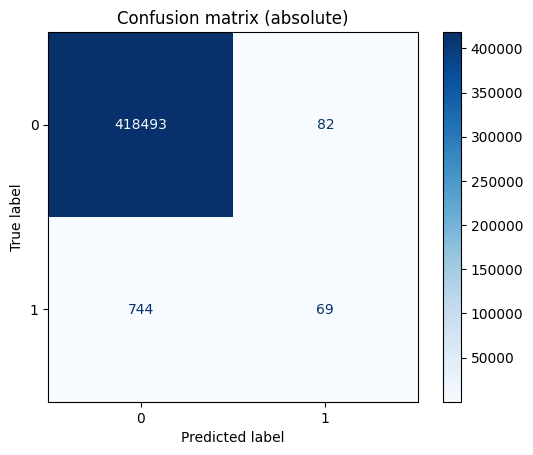

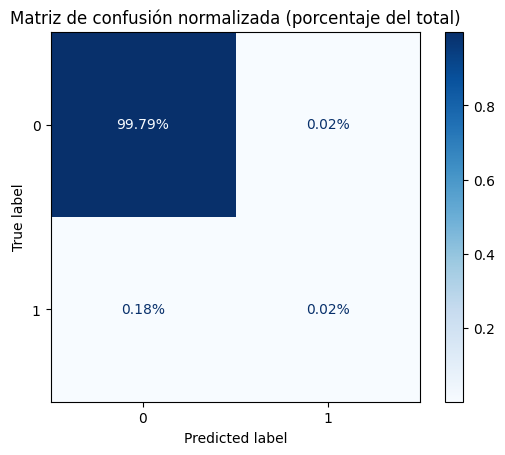

Accuracy: 0.9980
Recall:   0.0849
AUC: 0.9584


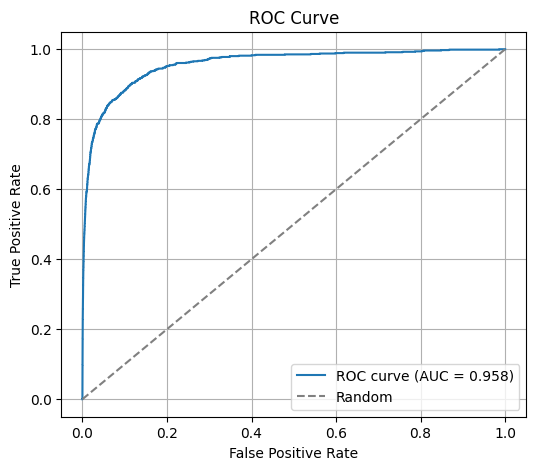

In [9]:
# Threshold = 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

# Confusion matrix (absolute)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Confusion matrix (absolute)")
plt.show()

# Confusion matrix (after normalization)
cm_norm = cm / cm.sum()

disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp_norm.plot(cmap="Blues", values_format=".2%")

plt.title("Matriz de confusión normalizada (porcentaje del total)")
plt.show()

# accuracy (how many targets the model predicts correctly?)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# recall (how many True Positive (conversion = 1) the model predicts correctly?
recall = recall_score(y_test, y_pred)
print(f"Recall:   {recall:.4f}")

# Curva ROC (TPR (recall) / FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# AUC score (probability that a positive has a higher score than a negative)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Despite the poor recall observed at a fixed classification threshold (0.5), the ROC-AUC indicates very strong ranking ability. In highly imbalanced problems such as conversion prediction, ROC-AUC is a more appropriate metric because it evaluates the model’s capacity to distinguish converters from non-converters independently of any threshold.

However... the score is absurdly high! This simple predictive model is extremely good given its simplicity... This means that the features are quite informative and so it is necessary to doubt about the "reality" of this dataset. 

The confusion matrix is included for interpretability purposes only. Given the extreme class imbalance, threshold-based classification metrics are misleading and reinforce the need for ranking-based and causal approaches rather than pure prediction. Even with good ranking performance (ROC-AUC), the model struggles to correctly identify converters at a fixed threshold


Performing the same model but only with one feature to measure its predictive power:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

print('Feature - AUC score')

for f in feature_cols:
    X_f = df[[f]]
    Xtr, Xte, ytr, yte = train_test_split(X_f, y, test_size=0.2, stratify=y, random_state=42
                                          )
    model_f = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=500, solver='lbfgs'))])
    model_f.fit(Xtr, ytr)
    auc = roc_auc_score(yte, model_f.predict_proba(Xte)[:,1])
    print(f, auc)


Feature - AUC score
f0 0.6547595980887242
f1 0.5770913834563897
f2 0.4144378260482121
f3 0.7430302851317352
f4 0.8846755498194652
f5 0.6248069891557184
f6 0.6944165390408608
f7 0.6186965234282338
f8 0.9370633054117676
f9 0.9211232496127146
f10 0.8649622074074172
f11 0.7902186171834842


These results show some answers to ROC-AUC model solution: the features *f4, f8, f9* and *f10* by themselves have a high predictive power.

Probably this dataset is not "realistic" and it was made for academic purposes. Or maybe the feature engineering perfomed to the features included some information about the outcome "conversion" and that information is encoded in the variables (leakage)...

In order to surpass this issue let's delete the 4 "best" features and repeat the model to make the problem more realistic and avoid trivial solutions



In [12]:
real_cols = ['f0','f1','f2','f3','f5','f6','f7','f11']

X = df[real_cols]
y = df['conversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500, solver='lbfgs'))
    ])

model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not w

In [14]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(f'Conversion rate in the prediction dataset: {np.round(y_pred_proba.mean()*100, 4)}%')

auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")


Conversion rate in the prediction dataset: 0.1919%
AUC: 0.8953


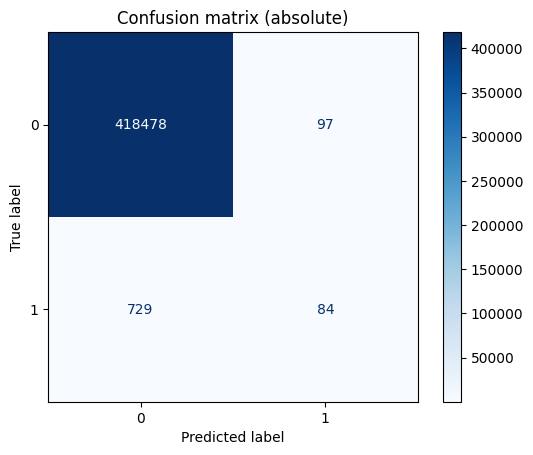

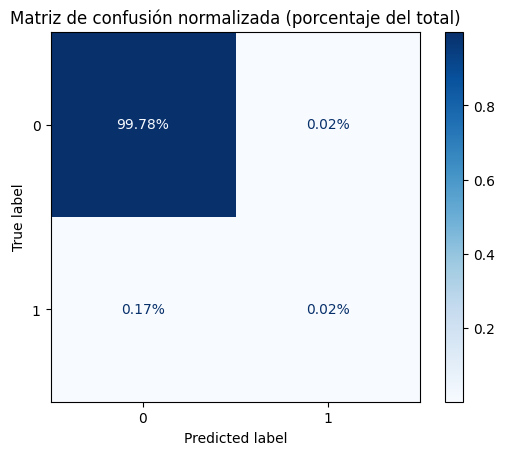

Accuracy: 0.9980
Recall:   0.1033
AUC: 0.8953


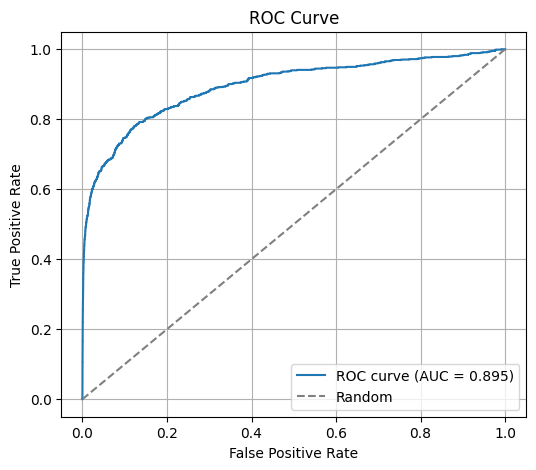

In [15]:
# Threshold = 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

# Confusion matrix (absolute)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Confusion matrix (absolute)")
plt.show()

# Confusion matrix (after normalization)
cm_norm = cm / cm.sum()

disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp_norm.plot(cmap="Blues", values_format=".2%")

plt.title("Matriz de confusión normalizada (porcentaje del total)")
plt.show()

# accuracy (how many targets the model predicts correctly?)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# recall (how many True Positive (conversion = 1) the model predicts correctly?
recall = recall_score(y_test, y_pred)
print(f"Recall:   {recall:.4f}")

# Curva ROC (TPR (recall) / FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# AUC score (probability that a positive has a higher score than a negative)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


### Conclusions 

A high ROC-AUC indicates strong ranking power, not necessarily good classification. In highly imbalanced conversion problems, it is common to have excellent discrimination without a meaningful decision threshold. Even after removing the most extreme features with strong predictive power, the remaining variables still allow the model to rank users by their probability of conversion.

High accuracy only implies that the model is pretty good predicting true negatives. This is expected due to the sky-high imbalanced of the dataset. The low recall implies this classifier does not predict true positive correctly.

The unusually high performance of some individual features suggests that the dataset contains highly engineered or near-outcome signals. For this reason, model coefficients should not be interpreted as causal drivers, and the model should be considered purely as a ranking baseline.

Propensity modeling alone is insufficient for treatment allocation. This baseline does not distinguish between users who benefit from treatment and those who do not. As a result, it cannot answer the core business question in marketing: who should be targeted to maximize incremental conversions.

This motivates the need for uplift modeling. To move from prediction to decision-making, we need to explicitly model the differential effect of the treatment by comparing outcomes under treatment and control conditions at the individual level.